# Predicting Global Game Sales

The data comes from [Kaggle](https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings#Video_Games_Sales_as_at_22_Dec_2016.csv) that was released in 2016. It is too old to study but there is no such available data that has similar features. 

Thus, the aim of this demonstration is to illustrate how regression models could be used to predict global game sales. I will use three regression models, including Lasso, Ridge and ElasticNet with cross validation tecnique.  I previously did the same analysis with the R program thus, the analysis also shows me how Pyhton works on the same data and compare their coding workflow. 




In [1]:
import os
data_path = ['data']

In [2]:
import pandas as pd
import numpy as np

In [3]:
filepath = os.sep.join(data_path + ['Video_Games_Sales_as_at_22_Dec_2016.csv'])
data = pd.read_csv(filepath)
data.head().T

,0,1,2,3,4
Name,Wii Sports,Super Mario Bros.,Mario Kart Wii,Wii Sports Resort,Pokemon Red/Pokemon Blue
Platform,Wii,NES,Wii,Wii,GB
Year_of_Release,2006.0,1985.0,2008.0,2009.0,1996.0
Genre,Sports,Platform,Racing,Sports,Role-Playing
Publisher,Nintendo,Nintendo,Nintendo,Nintendo,Nintendo
NA_Sales,41.36,29.08,15.68,15.61,11.27
EU_Sales,28.96,3.58,12.76,10.93,8.89
JP_Sales,3.77,6.81,3.79,3.28,10.22
Other_Sales,8.45,0.77,3.29,2.95,1.0
Global_Sales,82.53,40.24,35.52,32.77,31.37


In [4]:
# dimension of the data
data.shape

(16719, 16)

In [5]:
data.dtypes

Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Developer           object
Rating              object
dtype: object

Data has 16 variables and sales is my target variable. There are different sale amounts here but I am interested in Global Sales. As seen above, also some vaiables categories are not in true format. Let's see the initial graph about global game sales during years. 

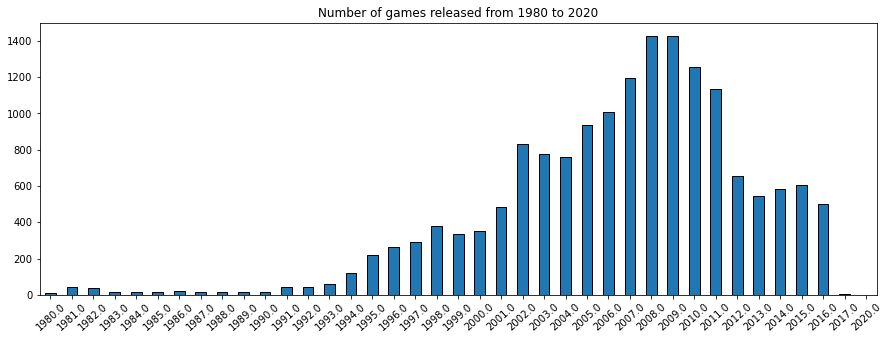

In [6]:
# let's see  the number of games sold globally 

import matplotlib.pyplot as plt
%matplotlib inline


data.groupby('Year_of_Release')['Name'].count().plot(
            kind='bar', y='name', figsize=(15,5), edgecolor='black'
)
plt.title('Number of games released from 1980 to 2020')
plt.xticks(rotation=42)
plt.xlabel('')
plt.show()



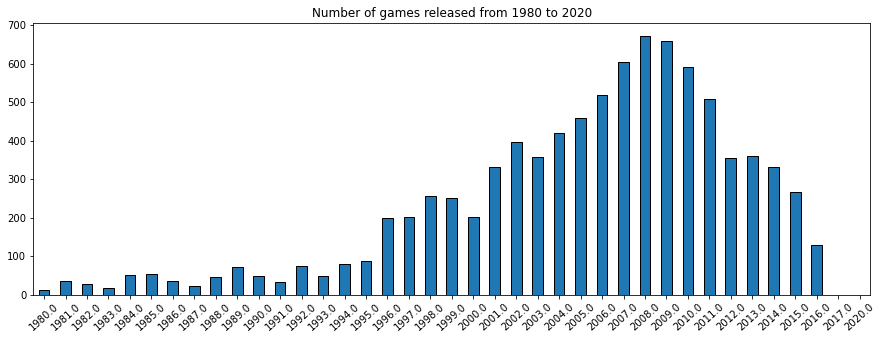

In [7]:

data.groupby('Year_of_Release')['Global_Sales'].sum().plot(
            kind='bar', y='name', figsize=(15,5), edgecolor='black'
)
plt.title('Number of games released from 1980 to 2020')
plt.xticks(rotation=42)
plt.xlabel('')
plt.show()
    

# Data preparation 



Although some of the features should be in numbers such as user scores and ratings, they are in object format. Besides, we have a date variable, __Years of Release__, I want to create a new variable from it as the age of games. But, first of all, lets check the missing values. 

In [8]:
data.count()

Name               16717
Platform           16719
Year_of_Release    16450
Genre              16717
Publisher          16665
NA_Sales           16719
EU_Sales           16719
JP_Sales           16719
Other_Sales        16719
Global_Sales       16719
Critic_Score        8137
Critic_Count        8137
User_Score         10015
User_Count          7590
Developer          10096
Rating              9950
dtype: int64

Some of our critical variables have huge amount of missing variables such as user/critic scores and critic/user counts. So, for the sake of the simplicity for this analysis, I will remove missing variable rows from the data. 

In [9]:
data= data.dropna()
data.count()

Name               6825
Platform           6825
Year_of_Release    6825
Genre              6825
Publisher          6825
NA_Sales           6825
EU_Sales           6825
JP_Sales           6825
Other_Sales        6825
Global_Sales       6825
Critic_Score       6825
Critic_Count       6825
User_Score         6825
User_Count         6825
Developer          6825
Rating             6825
dtype: int64

The value of global sales are not in their true unit, but I kept it as it is since multiplication only increase the  volume of the numbers.  I also change the data type of user and critic count/score as float. Finally, I created a new variable as the age of games.

In [10]:

data['Critic_Score']= (data['Critic_Score'].astype(str).astype(float)) / 10
data['Critic_Count']= (data['Critic_Count'].astype(str).astype(float)) 


data['User_Score']= (data['User_Score'].astype(str).astype(float)) 
data['User_Count']= (data['User_Count'].astype(str).astype(float)) 


data['Year_of_Release'] = (data['Year_of_Release'].astype(float).astype(int)) 
data['age'] = 2018 - data['Year_of_Release'] # new variables





I delete other variables since I will not include them into analysis. 

In [11]:
data= data.drop(['NA_Sales','EU_Sales', 'JP_Sales', 'Other_Sales', 'Year_of_Release', 'Name' , 'Publisher', 'Developer'], axis= 1)
data.head().T

,0,2,3,6,7
Platform,Wii,Wii,Wii,DS,Wii
Genre,Sports,Racing,Sports,Platform,Misc
Global_Sales,82.53,35.52,32.77,29.8,28.92
Critic_Score,7.6,8.2,8.0,8.9,5.8
Critic_Count,51.0,73.0,73.0,65.0,41.0
User_Score,8.0,8.3,8.0,8.5,6.6
User_Count,322.0,709.0,192.0,431.0,129.0
Rating,E,E,E,E,E
age,12,10,9,12,12


## Log transforming skew variables

I transform the skewed variable by taking their logs. I apply an automatic detecting process and set the treshold level as 0.75, which means that if variable has higher skeweness than this ratio, I will transform. 

In [12]:
# Create a list of float colums to check for skewing
mask = data.dtypes == float
float_cols = data.columns[mask]

skew_limit = 0.75 # define a limit above which we will log transform
skew_vals = data[float_cols].skew()




In [13]:
# Showing the skewed columns
skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {}'.format(skew_limit)))

skew_cols

,Skew
Global_Sales,16.094938
User_Count,8.666946
Critic_Count,1.030879
User_Score,-1.219349


In [14]:
# Perform the skew transformation:

for col in skew_cols.index.values:
    if col == "Global_Sales": # left the target outcome 
        continue
    data[col] = data[col].apply(np.log1p)

<AxesSubplot:>

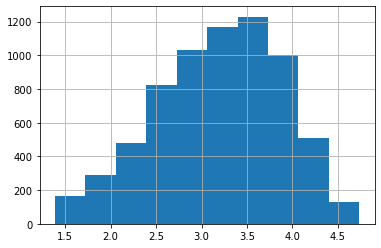

In [15]:
data['Critic_Count'].hist() # critic scorore



<AxesSubplot:>

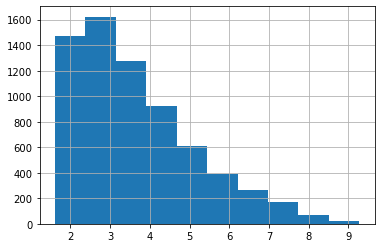

In [16]:
data['User_Count'].hist() # Critic Count

<AxesSubplot:>

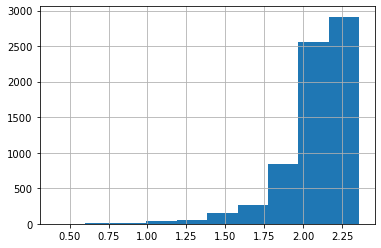

In [17]:
data['User_Score'].hist() # User score

## Platforms

First of all, let's check out distribution of games according to platforms. I also combine sub platforms with their main sources. As seen, most of the games were sold in Playstation platform, following by Nintendo and Xbox. The results show that people tend to play games mainly in these tree platforms.

In [18]:
data['Platform'] = data['Platform'].replace(["X360", "XB", "XOne"],'XBOX')
data['Platform'] = data['Platform'].replace(["Wii", "WiiU", "N64", "GC", "NES", "3DS", "DS"],'nintendo')
data['Platform'] = data['Platform'].replace(["PS", "PS2", "PS3", "PS4", "PSP", "PSV"],'playstation')
data['Platform'] = data['Platform'].replace(['GBA', 'DC'],'others')

<AxesSubplot:ylabel='Platform'>

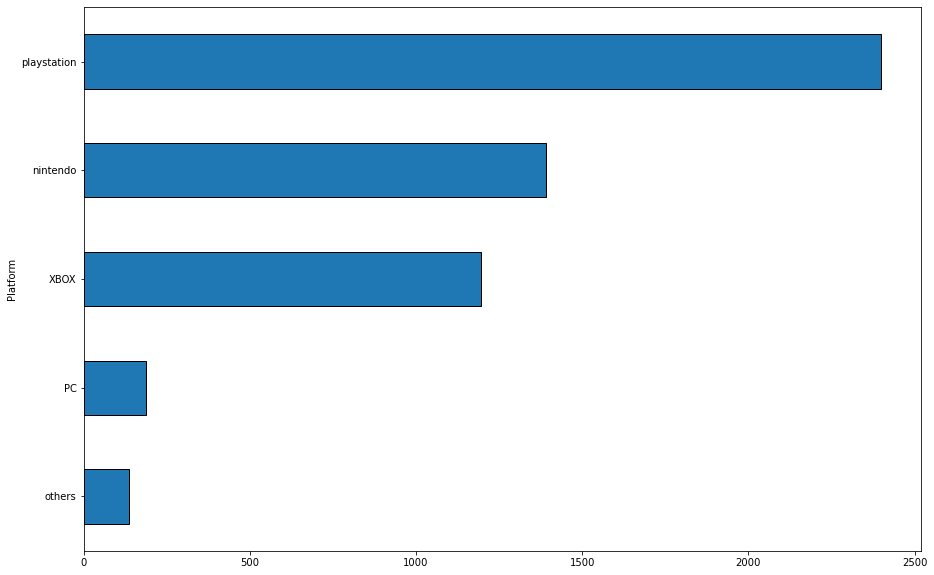

In [19]:
# Global game sales by Platforms

data.groupby('Platform')['Global_Sales'].sum().sort_values(ascending=True).plot(
            kind='barh', y='Global_Sales', figsize=(15,10), edgecolor='black'
)

We can plot the best-selling genre in Global Sales. We will use method groupby and usual plot, because we don’t need in very hard graph here. This plot is about genres and Global Sales around the world:

<AxesSubplot:xlabel='Genre'>

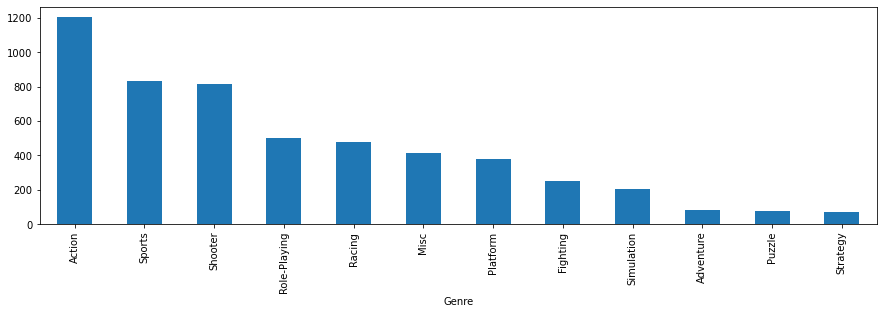

In [20]:
# size
plt.figure(figsize=(15, 4))

#the most global salable genre
data.groupby('Genre').sum().unstack().Global_Sales.sort_values(ascending=False).plot(kind='bar')

## Rating

I merged rare ratings with most relevant ones. You can see their distribution in bar plot

In [21]:
# ratings
data.Rating.value_counts()

T       2377
E       2082
M       1433
E10+     930
AO         1
K-A        1
RP         1
Name: Rating, dtype: int64

<AxesSubplot:xlabel='Rating'>

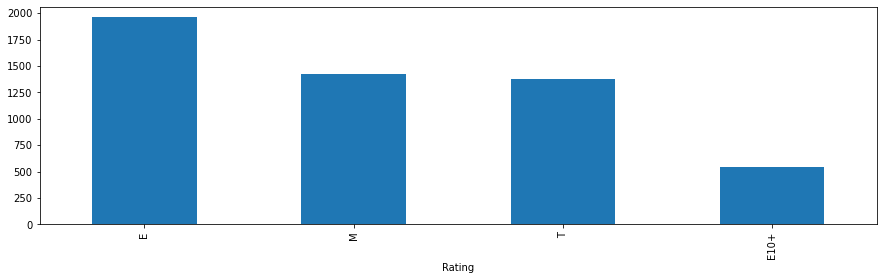

In [22]:
data['Rating'] = data['Rating'].replace(['AO'],'M')
data['Rating'] = data['Rating'].replace(['K-A'],'E')
data['Rating'] = data['Rating'].replace(['RP'],'E')

# size
plt.figure(figsize=(15, 4))

#the global game sales by Rating
data.groupby('Rating').sum().unstack().Global_Sales.sort_values(ascending=False).plot(kind='bar')


# Transforming target variable

Normally I was planning to do this process in model analysis section but since I started pre-processing, I continued in the same manner. I use boxcox method to transform target variable instead of using log transformation. The box cox transformation is a parametrized transformation that tries to get distributions "as close to a normal distribution as possible". You can search for more information about it. 

In [24]:
from scipy.stats import boxcox


In [25]:
bc_result = boxcox(data.Global_Sales)
boxcox_GS = bc_result[0]
lam = bc_result[1]

In [26]:
lam

-0.005664635199717148

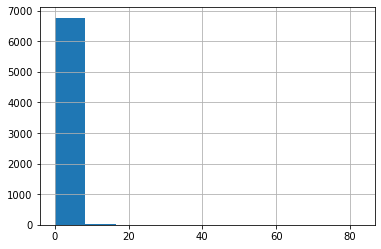

In [27]:
data['Global_Sales'].hist(); # original one

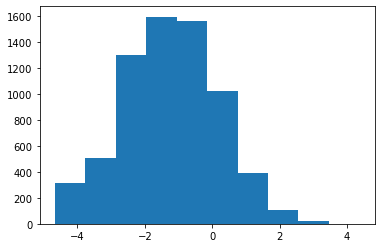

In [28]:
data['Global_Sales'] = boxcox_GS
plt.hist(boxcox_GS); # after the transformation

In [29]:
# we can also test its normality
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
# p needs to be > 0.05

normaltest(boxcox_GS)

NormaltestResult(statistic=7.502380904729207, pvalue=0.02348976575763621)

## Pairplot 

Before selecting our features for model building, it is important to know wheteher there is high correlation between our continuous variables.



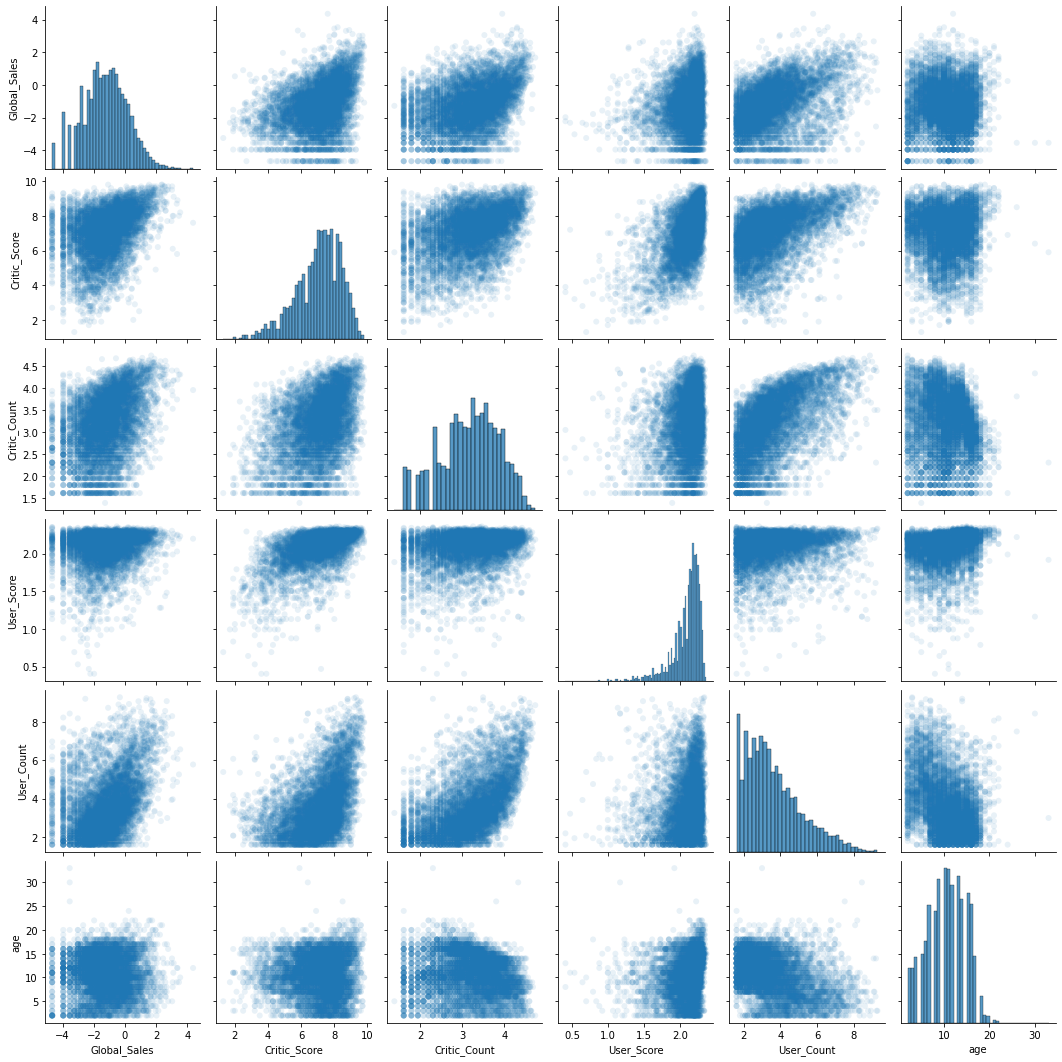

In [30]:


import seaborn as sns
#sns.pairplot(df, hue= 'Platform')

sns.pairplot(data, plot_kws=dict(alpha=.1, edgecolor='none'))

## One-hot encoding for dummy variables

We have some categorical variables that need to be converted into dummy variables. 

In [31]:
# Get a Pd.Series consisting of all the string categoricals
one_hot_encode_cols = data.dtypes[data.dtypes == object]  # filtering by string categoricals

one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields

data[one_hot_encode_cols].head().T 

,0,2,3,6,7
Platform,nintendo,nintendo,nintendo,nintendo,nintendo
Genre,Sports,Racing,Sports,Platform,Misc
Rating,E,E,E,E,E


In [32]:
# Do the one hot encoding
data = pd.get_dummies(data, columns=one_hot_encode_cols, drop_first=True)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_Sales,6825.0,-1.243308,1.408991,-4.665763,-2.221132,-1.242225,-0.287917,4.358456
Critic_Score,6825.0,7.027209,1.386857,1.300000,6.200000,7.200000,8.000000,9.800000
Critic_Count,6825.0,3.181045,0.691063,1.386294,2.708050,3.258097,3.688879,4.736198
User_Score,6825.0,2.082666,0.213358,0.405465,2.014903,2.140066,2.219203,2.360854
User_Count,6825.0,3.645997,1.507405,1.609438,2.484907,3.332205,4.499810,9.274816
age,6825.0,10.563223,4.211248,2.000000,7.000000,11.000000,14.000000,33.000000
Platform_XBOX,6825.0,0.231795,0.422010,0.000000,0.000000,0.000000,0.000000,1.000000
Platform_nintendo,6825.0,0.224908,0.417553,0.000000,0.000000,0.000000,0.000000,1.000000
Platform_others,6825.0,0.036777,0.188227,0.000000,0.000000,0.000000,0.000000,1.000000
Platform_playstation,6825.0,0.411136,0.492076,0.000000,0.000000,0.000000,1.000000,1.000000


In [33]:
# final dimension of the df
data.shape

(6825, 24)

# Regression Models with Course Tutorial

In [34]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

In [119]:
feature_cols = [x for x in data.columns if x != 'Global_Sales']
X = data[feature_cols]
y = data['Global_Sales']


####  Standardization and polynomial features

In [120]:
pf = PolynomialFeatures(degree=2, include_bias=True)
X_pf = pf.fit_transform(X)

In [121]:
s = StandardScaler()
X_ss = s.fit_transform(X_pf)

In [122]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_ss, y, random_state=42)

#Let's check the shape of the split data as a precaution
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))


X_train shape: (5118, 300)
y_train shape: (5118,)
X_test shape: (1707, 300)
y_test shape: (1707,)


In [123]:
# function for rmse

from sklearn.metrics import mean_squared_error

def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

### Linear regression

I will start with the basic linear regression

In [124]:

from sklearn.linear_model import LinearRegression

linearRegression = LinearRegression().fit(X_train, y_train)

linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))

print('RMSE score: ', linearRegression_rmse)


RMSE score:  0.9728188384883495


In [125]:
linear_predict = linearRegression.predict(X_test)

In [126]:
print('R square: ', r2_score(y_test, linear_predict))

R square:  0.5437142070862848


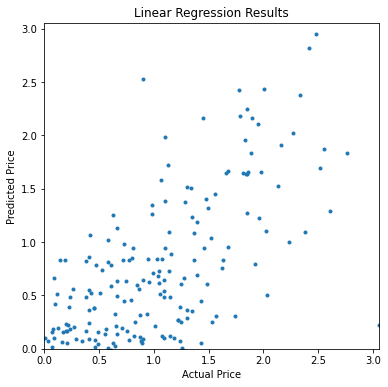

In [127]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(y_test, linearRegression.predict(X_test), 
         marker='o', ls='', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results');


### Ridge CV

In [128]:
from sklearn.linear_model import RidgeCV

alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

ridgeCV = RidgeCV(alphas=alphas, 
                  cv=4).fit(X_train, y_train)

ridgeCV_rmse = rmse(y_test, ridgeCV.predict(X_test))

print(ridgeCV.alpha_, ridgeCV_rmse)

30.0 0.962928107319967


In [129]:
ridge_predict = ridgeCV.predict(X_test)

In [130]:
print('R square: ', r2_score(y_test, ridge_predict))

R square:  0.5529452332746163


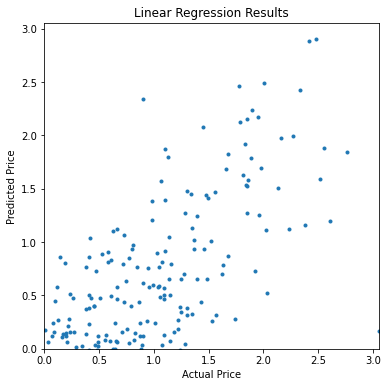

In [132]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(y_test, ridgeCV.predict(X_test), 
         marker='o', ls='', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results');

### Lasso CV

In [133]:
from sklearn.linear_model import LassoCV

alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])

lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=4).fit(X_train, y_train)

lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))

print(lassoCV.alpha_, lassoCV_rmse)  # Lasso is slower

0.0005 0.9644914649501585


In [134]:
lasso_predict = lassoCV.predict(X_test)

In [135]:
print('R square', r2_score(y_test, lasso_predict))

R square 0.5514924273411209


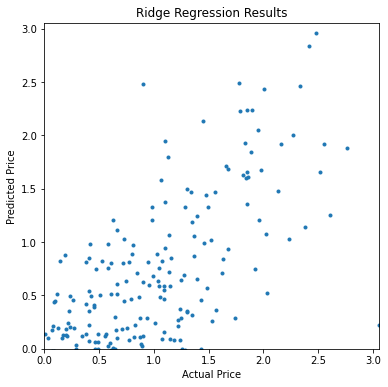

In [136]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(y_test, lassoCV.predict(X_test), 
         marker='o', ls='', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='Ridge Regression Results');

### Elastic 

In [138]:
from sklearn.linear_model import ElasticNetCV

l1_ratios = np.linspace(0.1, 0.9, 9)

elasticNetCV = ElasticNetCV(alphas=alphas2, 
                            l1_ratio=l1_ratios,
                            max_iter=1e5).fit(X_train, y_train)
elasticNetCV_rmse = rmse(y_test, elasticNetCV.predict(X_test))

print(elasticNetCV.alpha_, elasticNetCV.l1_ratio_, elasticNetCV_rmse)

0.0005 0.9 0.9648340129628826


In [139]:
elastic_predict = elasticNetCV.predict(X_train)

In [140]:
print('R square: ', r2_score(y_train, elastic_predict))

R square:  0.6052472030858538


### Models comparison  

In [141]:
rmse_vals = [linearRegression_rmse, ridgeCV_rmse, lassoCV_rmse, elasticNetCV_rmse]

labels = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']

rmse_df = pd.Series(rmse_vals, index=labels).to_frame()
rmse_df.rename(columns={0: 'RMSE'}, inplace=1)
rmse_df

,RMSE
Linear,0.972819
Ridge,0.962928
Lasso,0.964491
ElasticNet,0.964834


According to this table, the lowest RMSE score belongs to Ridge Regression. We can also make a plot of actual vs predicted housing prices as before.

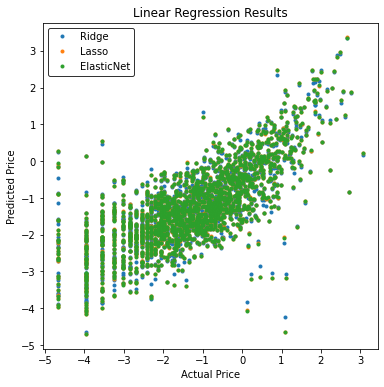

In [142]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

labels = ['Ridge', 'Lasso', 'ElasticNet']

models = [ridgeCV, lassoCV, elasticNetCV]

for mod, lab in zip(models, labels):
    ax.plot(y_test, mod.predict(X_test), 
             marker='o', ls='', ms=3.0, label=lab)


leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       title='Linear Regression Results');

## Testing Scale sensitivity

Let's explore Stochastic gradient descent in this exercise.
Recall that Linear models in general are sensitive to scaling. However, SGD is very sensitive to scaling.
Moreover, a high value of learning rate can cause the algorithm to diverge, whereas a too low value may take too long to converge.

SO, we can test out model to what extend its scales are sensitive

In [143]:
# Import SGDRegressor and prepare the parameters

from sklearn.linear_model import SGDRegressor

model_parameters_dict = {
    'Linear': {'penalty': 'none'},
    'Lasso': {'penalty': 'l2',
           'alpha': lassoCV.alpha_},
    'Ridge': {'penalty': 'l1',
           'alpha': ridgeCV_rmse},
    'ElasticNet': {'penalty': 'elasticnet', 
                   'alpha': elasticNetCV.alpha_,
                   'l1_ratio': elasticNetCV.l1_ratio_}
}

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test))

rmse_df['RMSE-SGD'] = pd.Series(new_rmses)
rmse_df

,RMSE,RMSE-SGD
Linear,0.972819,1.184688
Ridge,0.962928,1.441214
Lasso,0.964491,0.988518
ElasticNet,0.964834,0.974706


In [144]:
# Import SGDRegressor and prepare the parameters

from sklearn.linear_model import SGDRegressor

model_parameters_dict = {
    'Linear': {'penalty': 'none'},
    'Lasso': {'penalty': 'l2',
           'alpha': lassoCV.alpha_},
    'Ridge': {'penalty': 'l1',
           'alpha': ridgeCV_rmse},
    'ElasticNet': {'penalty': 'elasticnet', 
                   'alpha': elasticNetCV.alpha_,
                   'l1_ratio': elasticNetCV.l1_ratio_}
}

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(eta0=1e-7, **parameters)
    SGD.fit(X_train, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test))

rmse_df['RMSE-SGD-learningrate'] = pd.Series(new_rmses)
rmse_df

,RMSE,RMSE-SGD,RMSE-SGD-learningrate
Linear,0.972819,1.184688,1.889974
Ridge,0.962928,1.441214,1.890933
Lasso,0.964491,0.988518,1.889974
ElasticNet,0.964834,0.974706,1.889981


In [145]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train_scaled, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test_scaled))

rmse_df['RMSE-SGD-scaled'] = pd.Series(new_rmses)
rmse_df

,RMSE,RMSE-SGD,RMSE-SGD-learningrate,RMSE-SGD-scaled
Linear,0.972819,1.184688,1.889974,0.991142
Ridge,0.962928,1.441214,1.890933,1.440342
Lasso,0.964491,0.988518,1.889974,0.995664
ElasticNet,0.964834,0.974706,1.889981,0.992557


# Summary

1. In this demonstration, I used standardization and polynomial features on my X variables.
2. I also apply boxcox on target variable (y) since it is highly skewed. 
3. I tested four models and results indicate that ridge regression has the lowest rmse results. Nevertheless, when I applied different sensitivity scales, the order of the models could change. 
4. With the elasticnet regression, the R2 improved with a smaller increase in rmse.
5. For further improvement, tuning could be used.